<a href="https://colab.research.google.com/github/masonnystrom/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# given values for function 
false_positive_rate = .08 
true_positive_rate =  1 
prior_probability = 1/1000

0.001

In [0]:
# Write a function for drunk drivers
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):  
  result = ((true_positive_rate)*(prob_drunk_prior)) / ((true_positive_rate)*(prob_drunk_prior) + (false_positive_rate)*(1-prob_drunk_prior))
  return result
  

In [57]:
# What is the probability that a person is drunk after one positive breathalyzer test?
prob_drunk_given_positive(.001, .08, 1)

0.012357884330202669

In [59]:
# What is the probability that a person is drunk after two positive breathalyzer test?
prob_drunk_given_positive(.0123, .08, 1)

0.13469709579920275

In [60]:
# test 3
prob_drunk_given_positive(.134, .08, 1)

0.6591892955529319

In [62]:
# 4 tests to reach 95% probability that the drive is in fact drunk
# How many positive breathalyzer tests are needed in order to have a probability
# that's greater than 95% that a person is drunk beyond the legal limit?
prob_drunk_given_positive(.659, .08,1)

0.960249460861456

###Explore scipy.stats.bayes_mvs
Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:

In [0]:
coinflips = np.random.binomial(n=1, p=.5, size=10000)

In [97]:
# Confidence Interval the Bayesian way
conf_bayes = stats.bayes_mvs(coinflips, alpha=.95)[0][1] # need [0][1] to get only max and min of CI

conf_bayes

(0.48770030257581437, 0.5072996974241856)

In [74]:
# Confidence Interval the Frequentist way
conf_freq = stats.t.interval(.95, len(coinflips), loc=np.mean(coinflips), scale=stats.sem(coinflips))
conf_freq

(0.4876986262329494, 0.5073013737670506)

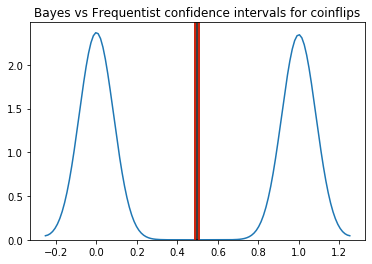

In [130]:
# plot with kernal density
sns.kdeplot(coinflips)

# axvlines
plt.axvline(x=conf_freq[0], color='green')
plt.axvline(x=conf_freq[1], color='green')

# bayes axes
plt.axvline(x=conf_bayes[0], color='red')
plt.axvline(x=conf_bayes[1], color='red')
plt.axvline(x=np.mean(coinflips), color='k')

#plot title
plt.title('Bayes vs Frequentist confidence intervals for coinflips')

#plot
plt.show()

###In your own words, summarize the difference between Bayesian and Frequentist statistics

Frequentists and Bayesians define probability differently.

TLDR: Frequentists fix models and vary data while Bayesians fix data and vary models

Frequentist statiticians believe that probabiliites of something is related to the frequency of events(i.e. flipping a coin). Frequentists can analyze the varying data using fixed models.

Bayesian statisticians apply probability to uncertainty in the inputs and outputs and gets rid of, or marginalizes parameters that are not as important. Essentially, Bayesian's analyze fixed data with models that vary around the data.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!

In [0]:
import pandas as pd
housing_df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

In [104]:
print(housing_df.shape)
housing_df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [105]:
housing_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [0]:
SalePrice_df = housing_df['SalePrice']

In [123]:
SalePrice_df.shape

(1460,)

In [108]:
house_price_bayes = stats.bayes_mvs(housing_df['SalePrice'], alpha=.95)[0][1]
house_price_bayes

(176847.62011261735, 184994.77166820454)

In [127]:
house_price_freq = stats.t.interval(0.95, len(SalePrice_df.shape),loc=np.mean(SalePrice_df), scale=stats.sem(SalePrice_df))
house_price_freq 


(154503.65797547717, 207338.73380534473)

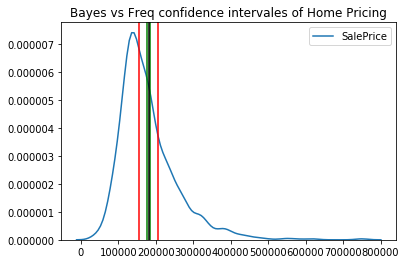

In [129]:
sns.kdeplot(SalePrice_df)

# axvlines
plt.axvline(x=house_price_freq[0], color='red')
plt.axvline(x=house_price_freq[1], color='red')

# bayes axes
plt.axvline(x=house_price_bayes[0], color='green')
plt.axvline(x=house_price_bayes[1], color='green')
plt.axvline(x=np.mean(SalePrice_df), color='k')

#plot title
plt.title('Bayes vs Freq confidence intervales of Home Pricing')

#plot
plt.show()